In [ ]:
%load_ext autoreload
%autoreload 2

device = 'cuda'

In [31]:
import torch 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Fully Connected Network

In [27]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

images = ['gogo', 'dionisios', 'fanourios', 'minos', 'saintjohn']

band_range = range(0, 4096)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(band_range.start, band_range.stop), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

## Training

In [46]:
# Fully Connected Network
from Elemental_Mapping.models.FullyConnectedModel import FullyConnectedModel 
from spec_db import pure_elements
from Elemental_Mapping.models.PriorLayer import PriorLayer 

# set as w the values of keys of pure_elements
w = torch.cat([pure_spectrum.unsqueeze(0) for pure_spectrum in pure_elements.values()], dim=0)
prior_layer = PriorLayer(
    w, s=None, bias=False, apply_sum=True, requres_grad=False, device='cuda') 

fcn = FullyConnectedModel(
    in_features=4096, 
    out_features=12, 
    hidden_dims=[512, 64, 64], 
    prior_layer=prior_layer,
    dropout=0.0
).to(device)

fcn

FullyConnectedModel(
  (layers): ModuleList(
    (0): PriorLayer()
    (1): Linear(in_features=12, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (prior_layer): PriorLayer()
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
)

In [9]:
from Elemental_Mapping.loss_functions.AdaptiveL1Loss import AdaptiveL1Loss

# Loss Function
train_criterion = AdaptiveL1Loss()
# Adam Optimizer
fcn_optimizer = torch.optim.Adam(fcn.parameters(), lr=1e-3)

In [ ]:
n_epochs = 2000
eval_n_epochs = 5
min_val_loss = np.inf
for epoch in range(n_epochs):
    train_loss = fcn.train(train_loader, fcn_optimizer, train_criterion, epochs=1, device='cuda')
    if epoch % eval_n_epochs == 0 and epoch > 0:
        eval_loss, _ = fcn.eval(val_loader, train_criterion, device='cuda')
    print(f'Epoch: {epoch}, Train Loss: {train_loss} Eval Loss: {eval_loss}')
    if eval_loss < min_val_loss:
        min_val_loss = eval_loss
        torch.save(fcn.state_dict(), f'./results/Elemental_Mapping/{fcn.alias}_best.pt')

## Evaluation

In [29]:
test_image = 'odigitria'

band_range = range(0, 4096)

test_dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=[test_image], 
    sample_step = 1, 
    device='cuda', 
    band_range=(band_range.start, band_range.stop), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [47]:
# load fcn state_dict
fcn.load_state_dict(torch.load(f'./results/Elemental_Mapping/{fcn.alias}_best.pt'))

<All keys matched successfully>

In [54]:
## Open target image file (elemental_maps)
df = pd.read_csv(f'/home/igeor/MSC-THESIS/data/h5/elem_maps/{test_image}.dat' , sep='  ', engine='python')
width, height = df['row'].iloc[-1] + 1, df['column'].iloc[-1] + 1
y_real = np.array(df[test_dataset.target_elems])

In [48]:
test_criterion = torch.nn.L1Loss()
test_loss, y_pred = fcn.eval(test_loader, test_criterion, device='cuda')

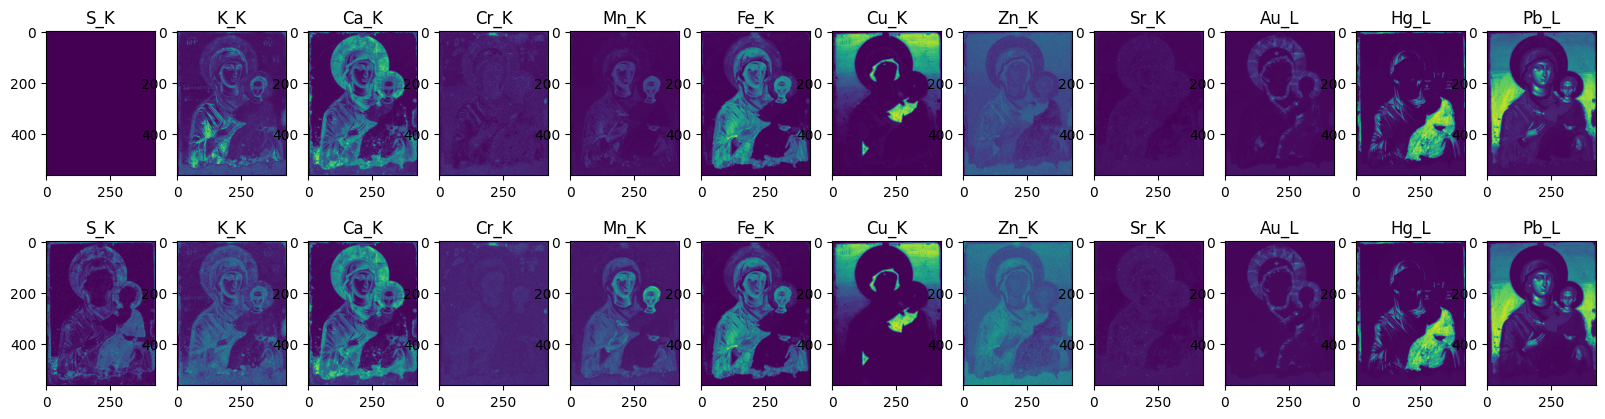

In [59]:
# first reshape y_pred and y_real to (12, w, h)
y_pred = y_pred.reshape((width, height, len(test_dataset.target_elems)))
y_real = y_real.reshape((width, height, len(test_dataset.target_elems)))

# plot the pred and real (12) image in a 2x12 grid
fix, axs = plt.subplots(2, len(test_dataset.target_elems), figsize=(20, 5))
for i in range(len(test_dataset.target_elems)):
    axs[0, i].imshow(y_pred[:,:,i].cpu().detach().numpy())
    axs[0, i].set_title(test_dataset.target_elems[i])
    axs[1, i].imshow(y_real[:,:,i])
    axs[1, i].set_title(test_dataset.target_elems[i])

# 1d Convolutional Network

In [60]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

images = ['gogo', 'dionisios', 'fanourios', 'minos', 'saintjohn']

band_range = range(0, 4096)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(band_range.start, band_range.stop), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)